In [1]:
import sys
sys.path.append('../../../models/ZoeDepth/')

import torch
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import csv
import pandas as pd
from PIL import Image
from pprint import pprint

/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
NYU_dataset_path = "path/nyu_depth_v2/official_splits/test"
test_split_nyu_path = "../../../models/ZoeDepth/train_test_inputs/nyudepthv2_test_files_with_gt.txt"

In [3]:
# read test split
with open(test_split_nyu_path, 'r') as f:
    test_split = f.readlines()
test_split = [x.strip() for x in test_split]


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")

pretrained_resource_org = 'url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt'

overwrite = {"pretrained_resource": pretrained_resource_org}
conf = get_config("zoedepth", "infer",**overwrite)
print(conf['pretrained_resource'])

print("Config:")
pprint(conf)

cuda
url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': False,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'clip_grad': 0.1,
 'dataset': 'ARkitScenes',
 'distributed': True,
 'force_keep_ar': True,
 'gpu': None,
 'img_size': [384, 512],
 'inverse_midas': False,
 'log_images_every': 0.1,
 'max_temp': 50.0,
 'max_translation': 100,
 'memory_efficient': True,
 'midas_model_type': 'DPT_BEiT_L_384',
 'min_temp': 0.0212,
 'model': 'zoedepth',
 'n_attractors': [16, 8, 4, 1],
 'n_bins': 64,
 'name': 'ZoeDepth',
 'notes': '',
 'output_distribution': 'logbinomial',
 'prefetch': False,
 'pretrained_resource': 'url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt',
 'print_losses': False,
 'project': 'ZoeDepth',
 'random_crop': False,
 'random_translate': False,
 'root': '.',
 'save_dir': '/home/ashka/ZoeDepth/che

In [5]:
model_pretrained = build_model(conf).to(DEVICE)

img_size [384, 512]


Using cache found in /home/ashkanganj/.cache/torch/hub/intel-isl_MiDaS_master
/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [6]:
model_pretrained.eval()

ZoeDepth(
  (core): MidasCore(
    (core): DPTDepthModel(
      (pretrained): Module(
        (model): Beit(
          (patch_embed): PatchEmbed(
            (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            (norm): Identity()
          )
          (pos_drop): Dropout(p=0.0, inplace=False)
          (blocks): ModuleList(
            (0-23): 24 x Block(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=1024, out_features=3072, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=1024, out_features=1024, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [7]:
def read_images(img_path, gt_path):
    gt_depth = cv2.imread(gt_path, cv2.IMREAD_ANYDEPTH)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # image = Image.open(img_path).convert("RGB")  # load
    return image, gt_depth


def rmse_valid_depths(predicted, gt):
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the squared difference between the two depth maps.
    sq_diff = (predicted - gt)**2

    # Calculate the mean squared difference for only valid depths.
    mse_valid = np.mean(sq_diff[valid_mask])

    # Calculate the RMSE for only valid depths.
    rmse_valid = np.sqrt(mse_valid)

    return rmse_valid



def relative_error_loss(predicted, gt):
    # Create a mask for valid pixels where ground truth values are greater than zero.
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the absolute difference between the predicted and ground truth depth maps.
    abs_diff = np.abs(predicted[valid_mask] - gt[valid_mask])

    # Calculate the relative error loss using the valid mask.
    rel_loss = np.mean(abs_diff / gt[valid_mask])

    return rel_loss



def absolute_relative_error(predicted, gt):
    valid_mask = (gt > 1e-3) & (gt < 10)

    # Calculate the absolute difference between the two depth maps.
    abs_diff = np.abs(predicted - gt)

    # Calculate the absolute relative error.
    abs_rel_err = np.mean(abs_diff[valid_mask] / predicted[valid_mask])

    return abs_rel_err

def calculate_errors(predicted, gt):
    # calculate rmse and abs_rel_err
    rmse = rmse_valid_depths(predicted, gt)
    abs_rel_err = relative_error_loss(predicted, gt)
    
    return rmse, abs_rel_err


def crop_image(image, crop_percentage):
    height, width = image.shape[:2]
    new_height = int(height - (height * crop_percentage / 100))
    new_width = int(width - (width * crop_percentage / 100))
    start_x = (width - new_width) // 2
    start_y = (height - new_height) // 2
    return image[start_y:start_y + new_height, start_x:start_x + new_width]


# An Example


In [8]:
example_img_path = os.path.join(NYU_dataset_path,test_split[0].split()[0])
example_gt_depth_path = os.path.join(NYU_dataset_path,test_split[0].split()[1])

In [9]:
example_img, example_gt_depth = read_images(example_img_path, example_gt_depth_path)
example_gt_depth = example_gt_depth.astype(np.float32) / 1000.0

In [10]:
# # Specify the output directory where the cropped images will be saved
# output_dir = "/path/to/output/directory/"

# # Save the cropped image
# cv2.imwrite(output_dir + "cropped_image.jpg", cropped_image)


In [11]:
pred_depth = model_pretrained.infer_pil(example_img)

inside forward Midas
Shape after prep:  torch.Size([1, 3, 384, 512])
Input size to Midascore torch.Size([1, 3, 384, 512])


Output from midas shape torch.Size([1, 384, 512])
inside forward Midas
Shape after prep:  torch.Size([1, 3, 384, 512])
Input size to Midascore torch.Size([1, 3, 384, 512])
Output from midas shape torch.Size([1, 384, 512])


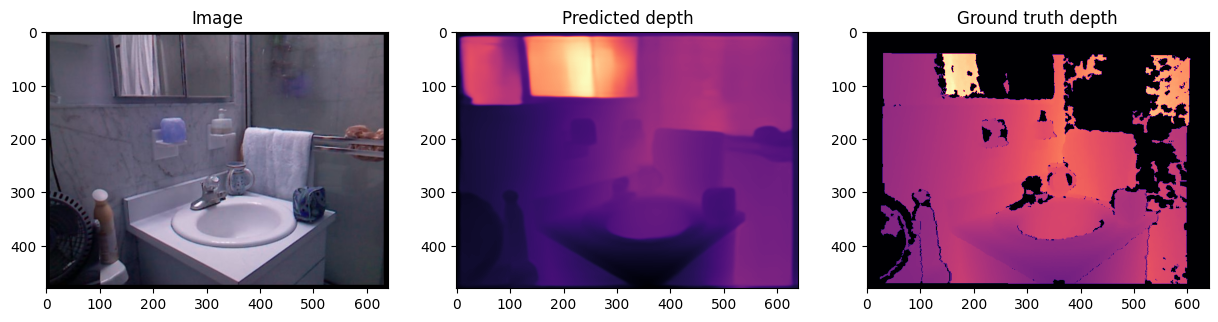

In [12]:
# visualize example image and depth with predicted depth and ground truth depth
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(example_img)
ax[0].set_title("Image")
ax[1].imshow(pred_depth, cmap='magma')
ax[1].set_title("Predicted depth")
ax[2].imshow(example_gt_depth, cmap='magma')
ax[2].set_title("Ground truth depth")
plt.show()

In [13]:
# calculate rmse and abs_rel
rmse  ,abs_rel = calculate_errors(pred_depth, example_gt_depth)
print("RMSE: ", rmse)
print("Abs_rel: ", abs_rel)

RMSE:  0.37215155
Abs_rel:  0.29301113


In [14]:
# crop image and depth
example_img_cropped = crop_image(example_img, 50)
example_gt_depth_cropped = crop_image(example_gt_depth, 50)
pred_depth_cropped = model_pretrained.infer_pil(example_img_cropped)

inside forward Midas
Shape after prep:  torch.Size([1, 3, 384, 512])
Input size to Midascore torch.Size([1, 3, 384, 512])
Output from midas shape torch.Size([1, 384, 512])
inside forward Midas
Shape after prep:  torch.Size([1, 3, 384, 512])
Input size to Midascore torch.Size([1, 3, 384, 512])
Output from midas shape torch.Size([1, 384, 512])


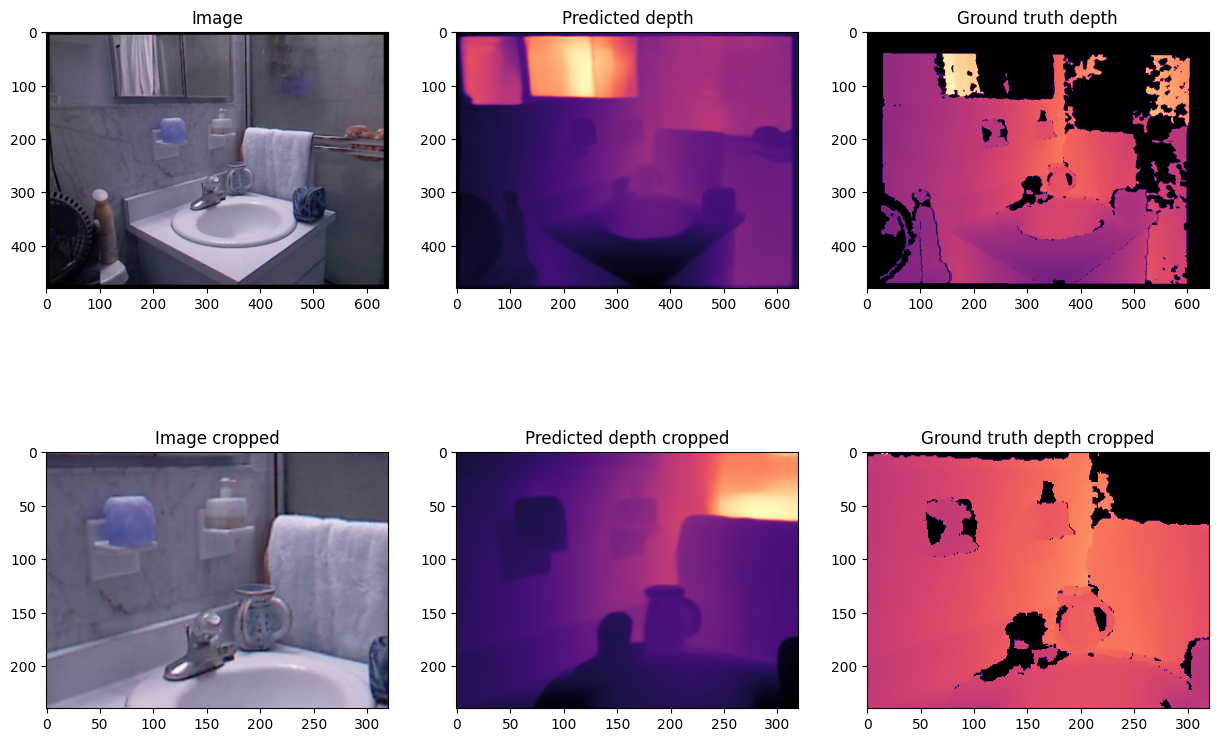

RMSE:  0.07785019
Abs_rel:  0.049389653


In [15]:
# visualize example image and depth with predicted depth and ground truth depth vs cropped image and depth
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(example_img)
ax[0, 0].set_title("Image")
ax[0, 1].imshow(pred_depth, cmap='magma')
ax[0, 1].set_title("Predicted depth")
ax[0, 2].imshow(example_gt_depth, cmap='magma')
ax[0, 2].set_title("Ground truth depth")
ax[1, 0].imshow(example_img_cropped)
ax[1, 0].set_title("Image cropped")
ax[1, 1].imshow(pred_depth_cropped, cmap='magma')
ax[1, 1].set_title("Predicted depth cropped")
ax[1, 2].imshow(example_gt_depth_cropped, cmap='magma')
ax[1, 2].set_title("Ground truth depth cropped")
plt.show()


# calculate rmse and abs_rel
rmse  ,abs_rel = calculate_errors(pred_depth_cropped, example_gt_depth_cropped)
print("RMSE: ", rmse)
print("Abs_rel: ", abs_rel)


## Run on all the test split of NYU

In [ ]:
cropped_percentage = [75, 50, 25]

with open('../../results/ZoeDepth/csv/cropped_percentage.csv', mode='w') as csv_file:
    fieldnames = ['sample', 'cropped_percentage', 'rmse_org',
                  'rel_org', 'rmse_cropped', 'rel_cropped']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for cropped_percentage in cropped_percentage:
        rmse_list = []
        abs_rel_list = []
        for sample in test_split:
            org_image, org_gt_depth = read_images(os.path.join(NYU_dataset_path, sample.split()[
                                                  0]), os.path.join(NYU_dataset_path, sample.split()[1]))
            cropped_image = crop_image(org_image, cropped_percentage)
            cropped_gt_depth = crop_image(org_gt_depth, cropped_percentage)

            org_gt_depth = org_gt_depth.astype(np.float32) / 1000.0
            cropped_gt_depth = cropped_gt_depth.astype(np.float32) / 1000.0

            pred_depth = model_pretrained.infer_pil(org_image)
            pred_depth_cropped = model_pretrained.infer_pil(cropped_image)

            rmse_org, rel_org = calculate_errors(pred_depth, org_gt_depth)
            rmse_cropped, rel_cropped = calculate_errors(
                pred_depth_cropped, cropped_gt_depth)

            # write to csv file
            writer.writerow({'sample': sample, 'cropped_percentage': cropped_percentage, 'rmse_org': rmse_org,
                            'rel_org': rel_org, 'rmse_cropped': rmse_cropped, 'rel_cropped': rel_cropped})


In [51]:
file_path = '../../results/ZoeDepth/csv/cropped_percentage.csv'
data = pd.read_csv(file_path)
data.head()


,sample,cropped_percentage,rmse_org,rel_org,rmse_cropped,rel_cropped
0,bathroom/rgb_00045.jpg bathroom/sync_depth_000...,75,0.372152,0.293011,0.230242,0.117587
1,bathroom/rgb_00046.jpg bathroom/sync_depth_000...,75,0.228066,0.073978,0.920136,0.403225
2,bathroom/rgb_00507.jpg bathroom/sync_depth_005...,75,0.258802,0.092091,1.274229,0.546498
3,bathroom/rgb_00508.jpg bathroom/sync_depth_005...,75,0.365724,0.147570,1.040984,0.350892
4,bathroom/rgb_00509.jpg bathroom/sync_depth_005...,75,0.263708,0.111023,0.573055,0.278616


In [52]:
non_numeric_columns = data.select_dtypes(exclude=['number'])

# Get the number of non-numeric columns
number_of_non_numeric_columns = len(non_numeric_columns.columns)
print(number_of_non_numeric_columns)

1


In [53]:
numeric_cols = data.select_dtypes(include=[np.number]) #remove non-numeric columns(header)
mean_data = numeric_cols.groupby('cropped_percentage').mean()

In [54]:
numeric_cols = data.select_dtypes(include=[np.number])
# mean_data = numeric_cols.groupby('cropped_percentage').mean()
grouped_data = numeric_cols.groupby('cropped_percentage').mean().reset_index()

### results that we used in paper

In [55]:
# print out RMSE for different cropped percentag
for index, row in grouped_data.iterrows():
    print("Cropped percentage: ", row['cropped_percentage'])
    print("RMSE: ", row['rmse_cropped'])
    print("Abs_rel: ", row['rel_cropped'])
    print("=====================================")


Cropped percentage:  25.0
RMSE:  0.4380801755397553
Abs_rel:  0.11944974474923546
Cropped percentage:  50.0
RMSE:  0.9349279971666667
Abs_rel:  0.2724151135504587
Cropped percentage:  75.0
RMSE:  1.5255718724250764
Abs_rel:  0.4265987893853211


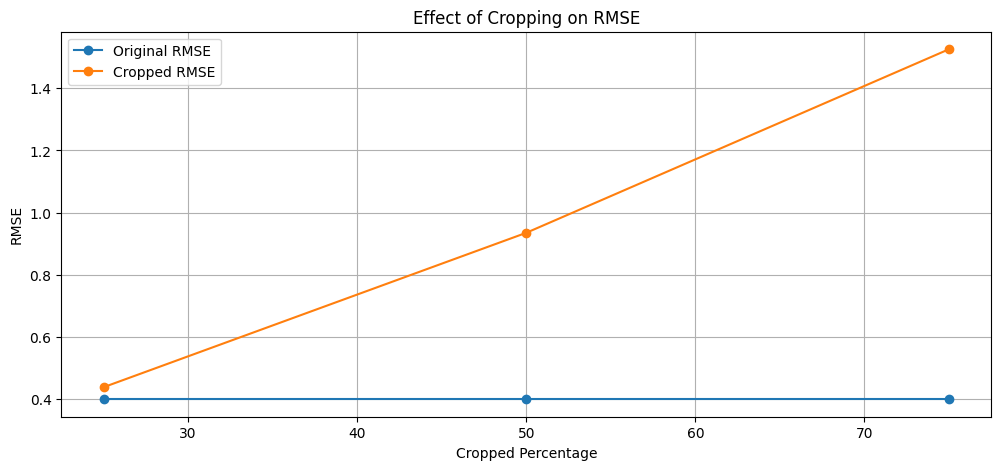

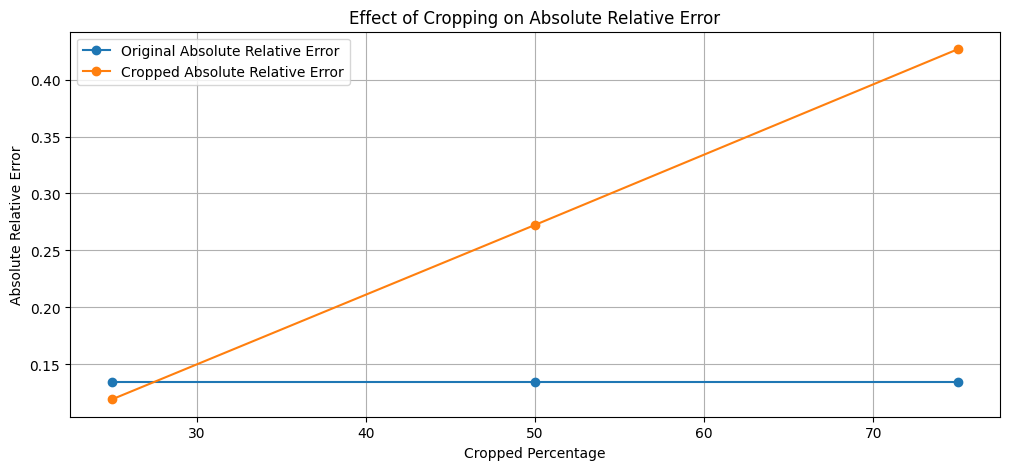

In [37]:
# Plotting RMSE
plt.figure(figsize=[12, 5])
plt.plot(grouped_data['cropped_percentage'], grouped_data['rmse_org'], label='Original RMSE', marker='o')
plt.plot(grouped_data['cropped_percentage'], grouped_data['rmse_cropped'], label='Cropped RMSE' , marker='o')
plt.xlabel('Cropped Percentage')
plt.ylabel('RMSE')
plt.title('Effect of Cropping on RMSE')
plt.legend()
plt.grid(True)
plt.savefig('../../results/ZoeDepth/figures/cropped_rmse.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plotting Absolute Relative Error
plt.figure(figsize=[12, 5])
plt.plot(grouped_data['cropped_percentage'], grouped_data['rel_org'], label='Original Absolute Relative Error' , marker='o')
plt.plot(grouped_data['cropped_percentage'], grouped_data['rel_cropped'], label='Cropped Absolute Relative Error' , marker='o')
plt.xlabel('Cropped Percentage')
plt.ylabel('Absolute Relative Error')
plt.title('Effect of Cropping on Absolute Relative Error')
plt.legend()
plt.grid(True)
plt.savefig('../../results/ZoeDepth/figures/cropped_rel.pdf', dpi=300, bbox_inches='tight')
plt.show()